In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#sns.set_style("darkgrid")
sns.set_theme(style="whitegrid")

import folium

In [2]:
df = pd.read_csv("CATI_LPK_MASZK_2021_10_hullam_2021_10_compl_20211030_clean_Renyi.csv",
           sep=';',
           header=0)

# Fix data
df = df.replace("Kömlő", "Kömlőd")
df = df.replace("Hódosér (bakonyszentlászló)", "Bakonyszentlászló")

# Merge KSH
KSH = pd.read_csv("HU_places_admin_pop_ZIP_latlon.csv",
           sep=',',
           header=0)
df=pd.merge(df, KSH, left_on="K15A", right_on="place")

# Add central Hungary
pest = ["Budapest"]+["Alsónémedi","Biatorbágy","Budajenő","Budakalász","Budakeszi","Budaörs","Csobánka","Csomád","Csömör","Csörög","Dabas","Délegyháza","Diósd","Dunabogdány","Dunaharaszti","Dunakeszi","Dunavarsány","Ecser","Erdőkertes","Érd","Felsőpakony","Fót","Göd","Gödöllő","Gyál","Gyömrő","Halásztelek","Herceghalom","Inárcs","Isaszeg","Kakucs","Kerepes","Kistarcsa","Kisoroszi","Leányfalu","Majosháza","Maglód","Mogyoród","Monor","Nagykovácsi","Nagytarcsa","Ócsa","Őrbottyán","Páty","Perbál","Pécel","Pilisborosjenő","Piliscsaba","Pilisjászfalu","Pilisszántó","Pilisszentiván","Pilisszentkereszt","Pilisszentlászló","Pilisvörösvár","Pomáz","Pócsmegyer","Pusztazámor","Remeteszőlős","Solymár","Sóskút","Szada","Százhalombatta","Szentendre","Szigethalom","Szigetmonostor","Szigetszentmiklós","Sződ","Sződliget","Tahitótfalu","Taksony","Tárnok","Telki","Tinnye","Tök","Tököl","Törökbálint","Újhartyán","Újlengyel","Üllő","Üröm","Vác","Vácrátót","Vecsés","Veresegyház","Visegrád","Zsámbék"]
no_pest = [k for k in set(df["K15A"].array) if k not in pest]
pest = [k for k in set(df["K15A"].array) if k in pest]

centralHun = pd.DataFrame({
    "central":np.concatenate((np.ones(len(pest), dtype=int), np.zeros(len(no_pest), dtype=int))),
    "K15A":pest+no_pest
})
df=df.merge(centralHun, on="K15A")

city_sizes = pd.read_csv("hnk_2019.csv", sep=",", skiprows=[1])
city_sizes = {r["Helység"]:float(r["Terület  (hektár)"].replace(',', '')) for i,r in city_sizes.iterrows()}

In [3]:
print(np.sqrt(0.01*city_sizes["Budapest"]), np.sqrt(0.01*city_sizes["Budakeszi"]))

df["city_sizes"] = df["K15A"].apply(lambda l:np.sqrt(0.01*city_sizes[l]))

22.915933321599624 6.0909769331364245


In [4]:
city_groups = df.groupby(["latitude","longitude", "K15A"])
koord_dict = city_groups.size()
responses_from_city = np.array(koord_dict.array)
koord = np.array([np.array([k[1], k[0]]) for k in koord_dict.index])
names = np.array([k[2] for k in koord_dict.index])
koord.shape

(447, 2)

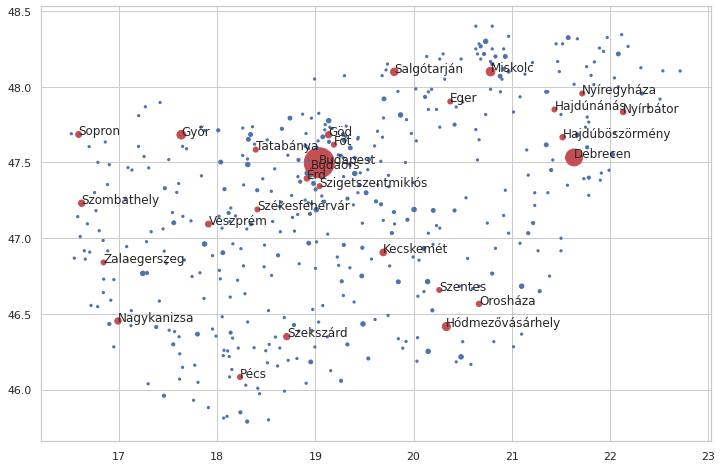

In [5]:
c = ['r' if size>4 else "b" for size in responses_from_city]
plt.figure(figsize=(12,8))
plt.scatter(koord[:,0], koord[:,1], s=(responses_from_city)*5, c=c)

for k, txt,size in zip(koord, names, responses_from_city):
    #if(txt in ["Budapest", "Győr", "Debrecen", "Kecskemét", "Pécs"]):
    if(size>4):
        plt.gca().annotate(txt, (k[0], k[1]))
        
plt.show()

In [6]:
def plot_awareness_map(key, title, koord, names, responses_from_city):
    c=None
    if(len(key)==1):
        c = city_groups[key[0]].mean()
    else:
        c = city_groups[key[0]].mean()-city_groups[key[1]].mean()
    cm = plt.cm.get_cmap('seismic')

    plt.figure(figsize=(12,8))
    plt.scatter(koord[:,0], koord[:,1], s=(responses_from_city)*5, c=c, cmap=cm)

    for k, txt,size in zip(koord, names, responses_from_city):
        if(size>6):
            plt.gca().annotate(txt, (k[0], k[1]))

    plt.title(title)
    plt.colorbar()
    plt.show()

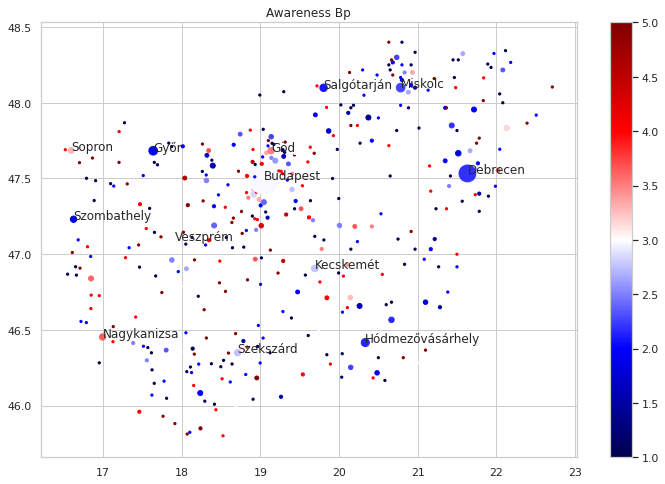

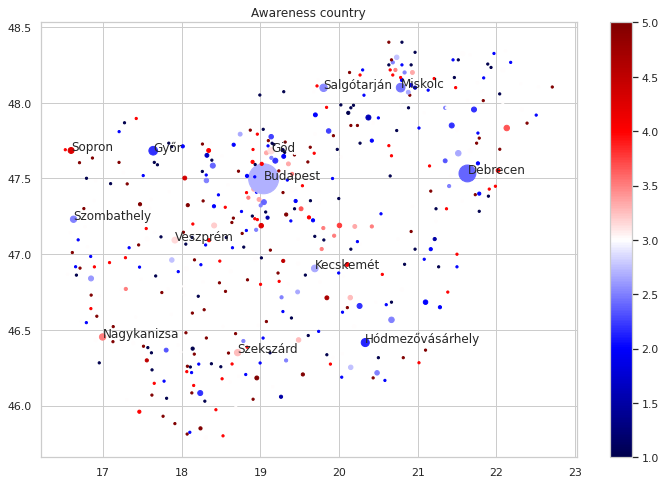

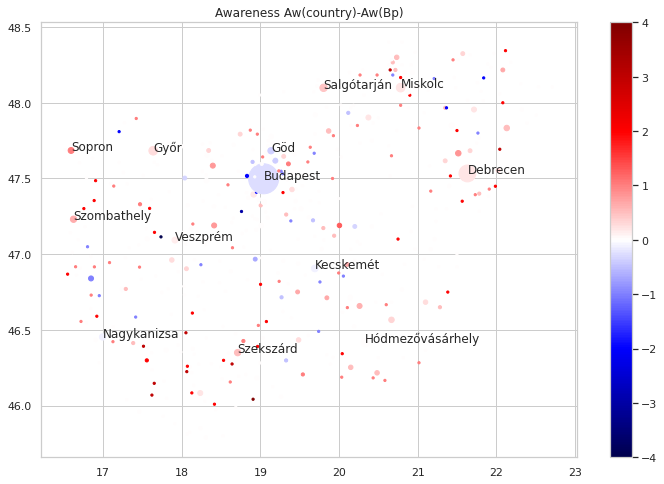

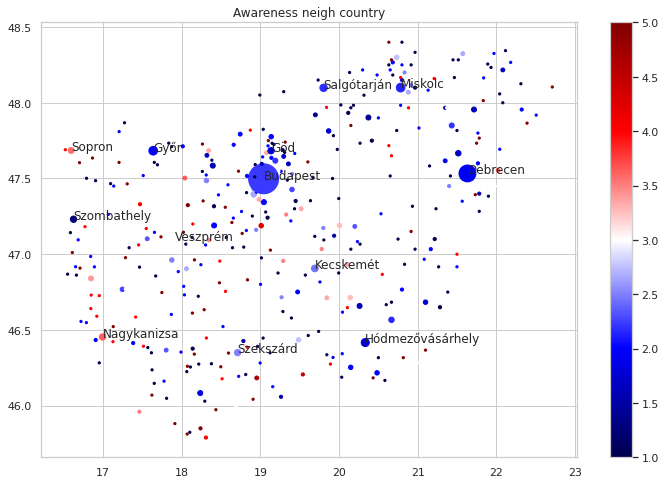

In [7]:
plot_awareness_map(["K91_05"], "Awareness Bp", koord, names, responses_from_city)
plot_awareness_map(["K91_06"], "Awareness country", koord, names, responses_from_city)
plot_awareness_map(["K91_06", "K91_05"], "Awareness Aw(country)-Aw(Bp)", koord, names, responses_from_city)
plot_awareness_map(["K91_07"], "Awareness neigh country", koord, names, responses_from_city)

In [8]:
city_groups.size().sort_values(ascending=False)[:20]

latitude  longitude  K15A             
47.49801  19.03991   Budapest             180
47.53330  21.63330   Debrecen              57
48.10000  20.78330   Miskolc               15
47.68330  17.63510   Győr                  15
46.41670  20.33330   Hódmezővásárhely      13
48.09870  19.80300   Salgótarján           11
46.90620  19.69130   Kecskemét              9
46.45350  16.99100   Nagykanizsa            8
47.23090  16.62160   Szombathely            8
46.35010  18.70910   Szekszárd              8
47.68320  19.13420   Göd                    8
47.09330  17.91150   Veszprém               7
47.68500  16.59050   Sopron                 7
47.83330  22.13330   Nyírbátor              6
47.39490  18.91360   Érd                    6
47.66670  21.51670   Hajdúböszörmény        6
46.56670  20.66670   Orosháza               6
47.34380  19.04340   Szigetszentmiklós      5
46.84000  16.84390   Zalaegerszeg           5
47.46180  18.95850   Budaörs                5
dtype: int64

In [9]:
from folium.plugins import HeatMap
def plot_folium_map(df, people, title):
    print(title)
    locations = people[["latitude", "longitude"]]
    print(len(people))

    
    m = folium.Map(location=[47.49801,  19.03991], zoom_start=7.4)
    
    HeatMap(locations).add_to(m)

    return m

In [10]:
people=df[df["K91_06"]-df["K91_05"]>0]
plot_folium_map(df, people, "Aw(country)-Aw(Bp) > 0")

Aw(country)-Aw(Bp) > 0
187


In [11]:
people=df[df["K91_06"]-df["K91_05"]<0]
plot_folium_map(df, people, "Aw(country)-Aw(Bp) < 0")

Aw(country)-Aw(Bp) < 0
95


In [12]:
people=df[df["K91_06"]-df["K91_05"]==0]
plot_folium_map(df, people, "Aw(country)-Aw(Bp) == 0")

Aw(country)-Aw(Bp) == 0
718


In [13]:
# Fontosabb a szomszéd ország: határ mentén ritkább?
people=df[df["K91_07"]-df["K91_06"]<0]
plot_folium_map(df, people, "Aw(neigh country)-Aw(country) < 0")

Aw(neigh country)-Aw(country) < 0
358


In [14]:
df.groupby("admin municip").size().sort_values(ascending=False)[:50];

In [15]:
state_geo = "stanford-dt251rh6351-geojson.json"
state_data = pd.DataFrame(df.groupby("admin county")[["K91_05", "K91_06", "K91_07"]].mean()).reset_index()
state_data = state_data.replace("főváros", "Budapest")
state_data = state_data.replace("Győr-Moson-Sopron", "Gyor-Moson-Sopron")
state_data["diff"]=state_data["K91_06"]-state_data["K91_05"]

In [16]:
m = folium.Map(location=[47.49801,  19.03991], zoom_start=7.4)

folium.Choropleth(
    geo_data=state_geo,
    data=state_data,
    columns=["admin county", "K91_05"],
    key_on="feature.properties.name_1",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Awareness",
    #bins=bins,
    reset=True,
).add_to(m)

m

In [17]:
m = folium.Map(location=[47.49801,  19.03991], zoom_start=7.4)

folium.Choropleth(
    geo_data=state_geo,
    data=state_data,
    columns=["admin county", "K91_06"],
    key_on="feature.properties.name_1",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Awareness",
    #bins=bins,
    reset=True,
).add_to(m)

m

In [18]:
#import folium.colormap as cm

def my_color_function(feature):
    if data_dict['feature.properties.Propinsi'] > 10000:
        return '#ff0000'
    else:
        return '#008000'

m = folium.Map(location=[47.49801,  19.03991], zoom_start=7.4)

folium.Choropleth(
    geo_data=state_geo,
    data=state_data,
    columns=["admin county", "diff"],
    key_on="feature.properties.name_1",
    fill_color="BuPu",
    #fill_color=cm.StepColormap(["red", "blue"], vmin=-5, vmax=5, index=[-5,0,5]),
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Awareness",
    #bins=bins,
    reset=True,
).add_to(m)

m

In [19]:
m = folium.Map(location=[47.49801,  19.03991], zoom_start=7.4)

folium.Choropleth(
    geo_data=state_geo,
    data=state_data,
    columns=["admin county", "K91_07"],
    key_on="feature.properties.name_1",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Unemployment Rate (%)",
    #bins=bins,
    reset=True,
).add_to(m)

m

In [20]:
df.groupby("admin county")["K91_07"].mean();

# Is Awareness larger in larger cities?

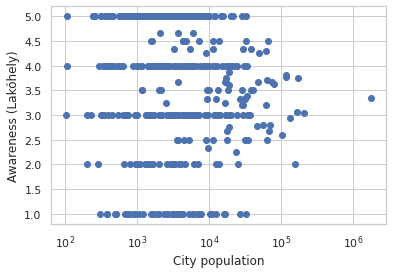

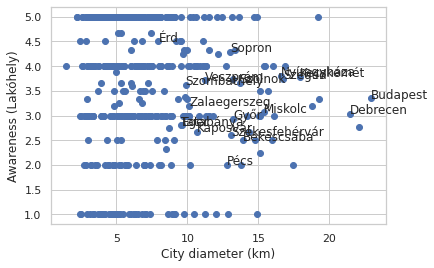

In [21]:
arr = df.groupby("K15A")[["K91_02", "population"]].mean()
plt.scatter(arr["population"].array, arr["K91_02"])
plt.xscale("log")
plt.xlabel("City population")
plt.ylabel("Awareness (Lakóhely)")
plt.show()

arr = df.groupby("K15A")[["K91_02", "city_sizes", "population"]].mean()
plt.scatter(arr["city_sizes"].array, arr["K91_02"])
plt.xlabel("City diameter (km)")
plt.ylabel("Awareness (Lakóhely)")

for txt,x,y,p in zip(arr.index,arr["city_sizes"].array, arr["K91_02"].array, arr["population"].array):
    if(p > 50000):
        plt.gca().annotate(txt, (x,y))
    
plt.show()

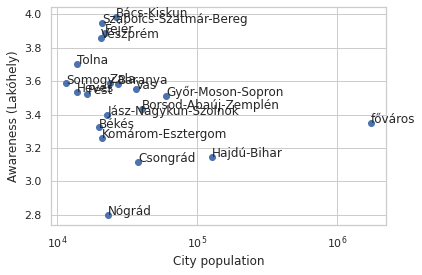

In [22]:
arr = df.groupby("admin county")[["K91_02", "population"]].mean()
plt.scatter(arr["population"].array, arr["K91_02"])
plt.xscale("log")
plt.xlabel("City population")
plt.ylabel("Awareness (Lakóhely)")

for txt,x,y in zip(arr.index,arr["population"].array, arr["K91_02"].array):
    plt.gca().annotate(txt, (x,y))
    
plt.show()
plt.show()

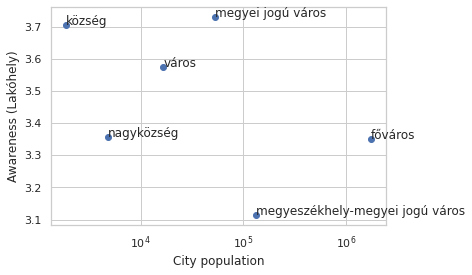

In [23]:
arr = df.groupby("settlement type")[["K91_02", "population"]].mean()
plt.scatter(arr["population"].array, arr["K91_02"])
plt.xscale("log")
plt.xlabel("City population")
plt.ylabel("Awareness (Lakóhely)")

for txt,x,y in zip(arr.index,arr["population"].array, arr["K91_02"]):
    plt.gca().annotate(txt, (x,y))

plt.show()

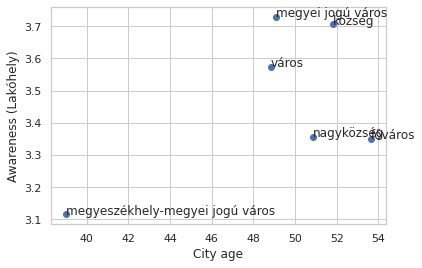

settlement type
főváros                            53.633333
község                             51.810811
megyei jogú város                  49.081081
megyeszékhely-megyei jogú város    39.028736
nagyközség                         50.881356
város                              48.828179
Name: SZUL, dtype: float64

In [24]:
arr = df.groupby("settlement type")[["K91_02", "SZUL"]].mean()
plt.scatter(arr["SZUL"].array, arr["K91_02"])
#plt.xscale("log")
plt.xlabel("City age")
plt.ylabel("Awareness (Lakóhely)")

for txt,x,y in zip(arr.index,arr["SZUL"].array, arr["K91_02"]):
    plt.gca().annotate(txt, (x,y))

plt.show()

df.groupby("settlement type")["SZUL"].mean()

# Távolság a megyeszékhelytől:

In [25]:
def l2(lat1,long1,county):
    lat2,long2 = county[1],county[2]
    return np.sqrt((lat2-lat1)**2+(long2-long1)**2)

def get_km(lat1,long1,county):
    lat2,long2 = county[1],county[2]
    
    lat1 = 2*np.pi*lat1/360
    lat2 = 2*np.pi*lat2/360
    long1 = 2*np.pi*long1/360
    long2 = 2*np.pi*long2/360
    
    R=6371
    a = np.sin((lat2-lat1)/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((long2-long1)/2)**2
    c = 2 * np.arctan2( np.sqrt(a), np.sqrt((1-a)) )
    d = R * c
    
    return d

megyeszekhely = df[df["settlement type"]=="megyeszékhely-megyei jogú város"].groupby(["K15A","admin county","latitude","longitude"]).size()
d_megyeszek = {r[1]:(r[0],r[2],r[3]) for r in megyeszekhely.index}
d_megyeszek["főváros"]=("Budapest",47.49801,19.03991)
d_megyeszek["Pest"]=("Budapest",47.49801,19.03991)

print(df[df["K15A"]=="Budapest"][["latitude","longitude"]].iloc[0])
d_megyeszek

latitude     47.49801
longitude    19.03991
Name: 69, dtype: float64


{'Békés': ('Békéscsaba', 46.6833, 21.1),
 'Hajdú-Bihar': ('Debrecen', 47.5333, 21.6333),
 'Heves': ('Eger', 47.9026, 20.3733),
 'Győr-Moson-Sopron': ('Győr', 47.6833, 17.6351),
 'Somogy': ('Kaposvár', 46.3667, 17.8),
 'Bács-Kiskun': ('Kecskemét', 46.9062, 19.6913),
 'Borsod-Abaúj-Zemplén': ('Miskolc', 48.1, 20.7833),
 'Szabolcs-Szatmár-Bereg': ('Nyíregyháza', 47.9554, 21.7167),
 'Baranya': ('Pécs', 46.0833, 18.2333),
 'Nógrád': ('Salgótarján', 48.0987, 19.803),
 'Csongrád': ('Szeged', 46.253, 20.1482),
 'Tolna': ('Szekszárd', 46.3501, 18.7091),
 'Jász-Nagykun-Szolnok': ('Szolnok', 47.1833, 20.2),
 'Vas': ('Szombathely', 47.2309, 16.6216),
 'Fejér': ('Székesfehérvár', 47.1899, 18.4103),
 'Komárom-Esztergom': ('Tatabánya', 47.5849, 18.3933),
 'Veszprém': ('Veszprém', 47.0933, 17.9115),
 'Zala': ('Zalaegerszeg', 46.84, 16.8439),
 'főváros': ('Budapest', 47.49801, 19.03991),
 'Pest': ('Budapest', 47.49801, 19.03991)}

In [26]:
df["dist_from_county_center"]=df.apply(
    lambda l: get_km(l["latitude"],l["longitude"],d_megyeszek[l["admin county"]]),
    axis=1)

df["dist_from_Bp"]=df.apply(
    lambda l: get_km(l["latitude"],l["longitude"],(0,47.49801, 19.03991)),
    axis=1)

In [27]:
arr = df.groupby(["K15A", "dist_from_county_center"]).size();
sorted(np.array(arr.index), key=lambda l:l[1], reverse=True)[:30]

[('Nagybaracska', 113.31586193675624),
 ('Madaras', 99.82542693120261),
 ('Baja', 98.25426665870397),
 ('Bácsbokod', 96.031432944319),
 ('Ricse', 91.4874365949193),
 ('Sükösd', 87.46087016121238),
 ('Cigánd', 83.99988872929805),
 ('Ágfalva', 83.72759370837986),
 ('Abony', 80.36732030343698),
 ('Dusnok', 79.83472201895194),
 ('Törtel', 79.51442763443457),
 ('Tompa', 78.71257778953469),
 ('Sopron', 78.19664314639827),
 ('Nagykőrös', 75.9375945769525),
 ('Tiszakóród', 75.88621152317232),
 ('Érsekhalma', 75.72753482564977),
 ('Nyársapát', 73.20156487313429),
 ('Jánoshalma', 73.10472433501359),
 ('Miske', 71.66303905968645),
 ('Nagycenk', 70.80156915390734),
 ('Vajdácska', 69.75591419355963),
 ('Kalocsa', 68.93390032237691),
 ('Cegléd', 67.71199730046261),
 ('Lövő', 66.78743097386055),
 ('Zákány', 66.03481439808357),
 ('Csemő', 64.76515433119397),
 ('Sárospatak', 63.67116532474261),
 ('Tarpa', 63.24798054243968),
 ('Siófok', 62.919118028915875),
 ('Szakmár', 61.03878280927293)]

In [28]:
arr = df.groupby(["K15A", "dist_from_Bp"]).size();
sorted(np.array(arr.index), key=lambda l:l[1], reverse=True)[-10:]

[('Halásztelek', 15.78726832369484),
 ('Csömör', 15.629665844357785),
 ('Érd', 14.888653161709916),
 ('Solymár', 13.261691504214497),
 ('Törökbálint', 12.18738916335605),
 ('Diósd', 11.98267665095961),
 ('Üröm', 11.122023061897641),
 ('Budakeszi', 8.584931514085508),
 ('Budaörs', 7.324072199898709),
 ('Budapest', 0.0)]

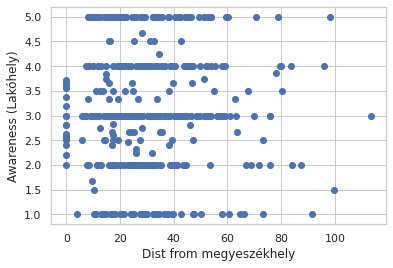

In [29]:
arr=df.groupby("K15A")[["K91_03", "dist_from_county_center"]].mean();
plt.scatter(arr["dist_from_county_center"].array, arr["K91_03"])
plt.xlabel("Dist from megyeszékhely")
plt.ylabel("Awareness (Lakóhely)")

plt.show()

# Awareness from Budapest

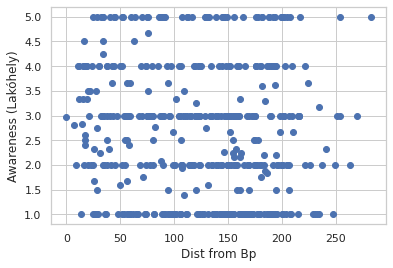

In [30]:
arr=df.groupby("K15A")[["K91_05", "dist_from_Bp"]].mean();
plt.scatter(arr["dist_from_Bp"].array, arr["K91_05"])
plt.xlabel("Dist from Bp")
plt.ylabel("Awareness (Lakóhely)")

plt.show()

# All togeather

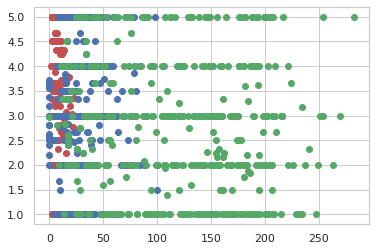

In [31]:
arr = df.groupby("K15A")[["K91_02", "city_sizes", "population"]].mean()
plt.scatter(arr["city_sizes"], arr["K91_02"], c='r')

arr=df.groupby("K15A")[["K91_03", "dist_from_county_center"]].mean();
plt.scatter(arr["dist_from_county_center"], arr["K91_03"], c='b')

arr=df.groupby("K15A")[["K91_05", "dist_from_Bp"]].mean();
plt.scatter(arr["dist_from_Bp"], arr["K91_05"],  c='g')

With singleton cities: 447
Filtered: 69


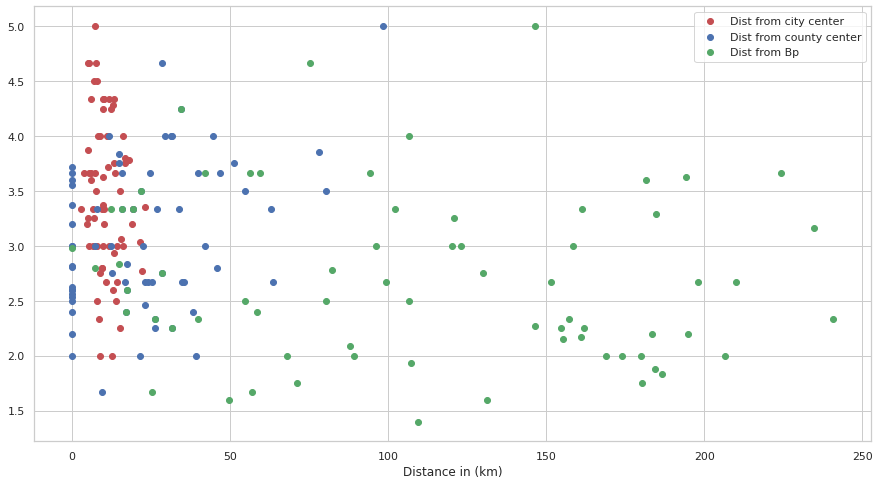

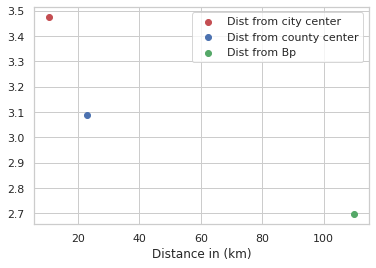

In [32]:
arr = df.groupby("K15A").agg({
    "K91_02":'mean',
    "K91_03":'mean',
    "K91_05":'mean',
    "súly":"sum",
    "city_sizes":"min",
    "population":"min",
    "dist_from_county_center":"min",
    "dist_from_Bp":"min",
})
print(f"With singleton cities: {len(arr)}")
arr = arr[arr["súly"]>2.5]
print(f"Filtered: {len(arr)}")

plt.figure(figsize=(15,8))
plt.scatter(arr["city_sizes"], arr["K91_02"], c='r', label="Dist from city center")
plt.scatter(arr["dist_from_county_center"], arr["K91_03"], c='b', label="Dist from county center")
plt.scatter(arr["dist_from_Bp"], arr["K91_05"],  c='g', label="Dist from Bp")
plt.xlabel("Distance in (km)")
plt.legend()
plt.show()

#plt.figure(figsize=(15,8))
plt.scatter(np.mean(arr["city_sizes"]), np.mean(arr["K91_02"]), c='r', label="Dist from city center")
plt.scatter(np.mean(arr["dist_from_county_center"]), np.mean(arr["K91_03"]), c='b', label="Dist from county center")
plt.scatter(np.mean(arr["dist_from_Bp"]), np.mean(arr["K91_05"]),  c='g', label="Dist from Bp")
plt.xlabel("Distance in (km)")
plt.legend()
plt.show()

In [33]:
df.groupby("admin county").size().sort_values(ascending=False);